In [108]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

class TRIMA_CDL(CtaTemplate):
    className = 'TRIMA_CDL'
    author = 'pengyacheng'

    amWindow = 20
    # 策略参数
    smaPeriod = 25; lmaPeriod = 65

    lot = 1
    

    
    # 策略变量
    transactionPrice = {} # 记录成交价格
  
    maTrend={}
    
    # 参数列表，保存了参数的名称
    paramList = [
                 
                 'smaPeriod', 'lmaPeriod',
                 ]  
    
    # 变量列表，保存了变量的名称
    varList = ['transactionPrice'] 
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList}
        
        self.CDL = {s:0 for s in self.symbolList}
        self.putEvent()
        self.maTrend = {s:0 for s in self.symbolList}

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def stopLoss(self,bar):#止盈止损
        # 设置参数
        stopLossPct = 0.01 #百分之一
        takeProfitPct = 0.1 #百分之十

        # 计算止损止盈价位
        longStop = self.transactionPrice*(1-self.stopLossPct)
        longProfit = self.transactionPrice*(1+self.takeProfitPct)
        shortStop = self.transactionPrice*(1-self.stopLossPct)
        shortProfit = self.transactionPrice*(1+self.takeProfitPct)

        # 持有多头
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close<= longStop) or (bar.close>=longProfit):
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])

        # 持有空头
        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close>shortStop) or (bar.close<shortProfit):
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])
                
    def on60MinBar(self, bar):
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        fastMa = ta.TRIMA(am60.close, self.smaPeriod)
        slowMa = ta.TRIMA(am60.close, self.lmaPeriod)
        
        if (fastMa[-1] > slowMa[-1]):
            self.maTrend[symbol] = 1
        elif (fastMa[-1]<slowMa[-1]):
            self.maTrend[symbol] = -1
            
       
      
        # 发出状态更新事件
        self.putEvent()

    def on15MinBar(self, bar):
        symbol = bar.vtSymbol
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return
        doji = ta.CDLDRAGONFLYDOJI  (am15.open.reshape(-1), am15.high.reshape(-1),am15.low.reshape(-1), am15.close.reshape(-1))
        
        haning=ta.CDLHANGINGMAN(am15.open.reshape(-1), am15.high.reshape(-1),am15.low.reshape(-1), am15.close.reshape(-1))
    
    
        #long trend
        if (doji[-1]==100)and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close, self.lot)  # 
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close, self.lot)
        
        # short trend
        if (haning[-1]==-100) and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
#                 self.cancelAll() # 撤销挂单
                self.short(symbol, bar.close, self.lot) # 
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close, self.lot)
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#             print(trade.tradeTime, self.posDict)

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [106]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function TRIMA_CDL.on60MinBar at 0x0000019C87B94730>, <__main__.TRIMA_CDL object at 0x0000019C8BA65FD0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function TRIMA_CDL.on15MinBar at 0x0000019C87B94510>, <__main__.TRIMA_CDL object at 0x0000019C8BA65FD0>)
2018-12-17 20:41:28.514115	开始回测
2018-12-17 20:41:28.514115	策略初始化
2018-12-17 20:41:28.516137	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-17 20:41:29.007819	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 20:41:29.010784	载入完成，数据量：12000
2018-12-17 20:41:29.011781	策略初始化完成
2018-12-17 20:41:29.011781	策略启动完成
2018-12-17 20:41:29.011781	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-17 20:41:29.032751	载入历史数据。数据范围:[20180601 12:00,20181201 12:00)
2018-12-17 20:41:40.210859	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-17 20:41:40.283664	载入完成，数据量：261008
2018-12-17 20:41:40.284667	当前回放数据:[20

Traceback (most recent call last):
  File "C:\Users\peng\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.13.dev1811227-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\Users\peng\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


2018-12-17 20:41:40.508042	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 20:41:40.509067	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-17 20:41:40.529013	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-17 20:41:42.390008	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 20:41:42.410978	载入完成，数据量：53630
2018-12-17 20:41:42.416964	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-17 20:41:42.447876	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 20:41:42.447876	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时

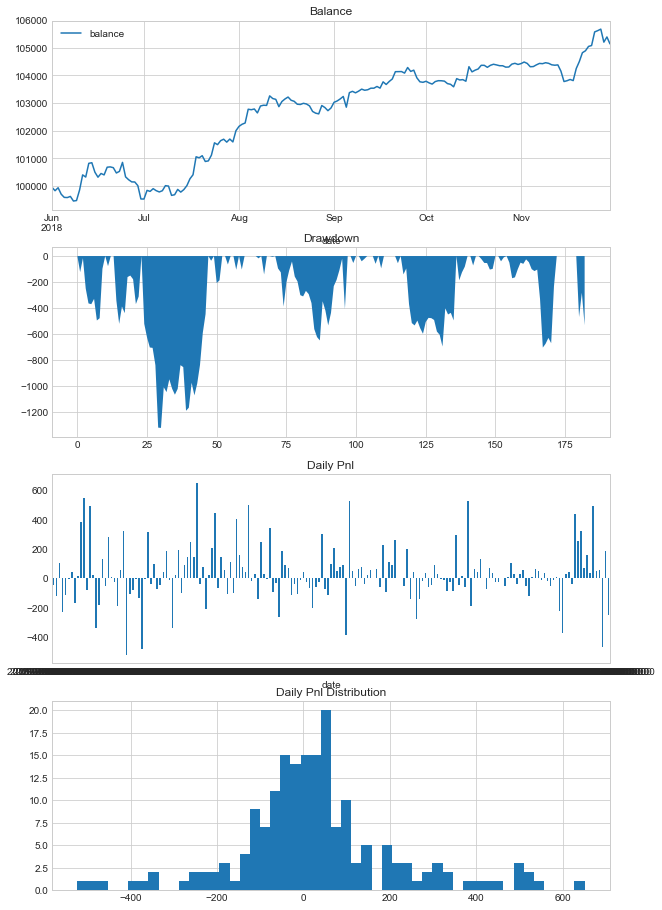

2018-12-17 20:42:02.231969	计算回测结果
2018-12-17 20:42:02.238924	------------------------------
2018-12-17 20:42:02.238924	第一笔交易：	2018-06-02 09:30:00
2018-12-17 20:42:02.238924	最后一笔交易：	2018-11-30 23:58:00
2018-12-17 20:42:02.238924	总交易次数：	69
2018-12-17 20:42:02.238924	总盈亏：	5,141.25
2018-12-17 20:42:02.239957	最大回撤: 	-1,129.82
2018-12-17 20:42:02.239957	平均每笔盈利：	74.51
2018-12-17 20:42:02.239957	平均每笔滑点：	0.0
2018-12-17 20:42:02.239957	平均每笔佣金：	6.63
2018-12-17 20:42:02.239957	胜率		49.28%
2018-12-17 20:42:02.239957	盈利交易平均值	287.38
2018-12-17 20:42:02.239957	亏损交易平均值	-132.28
2018-12-17 20:42:02.239957	盈亏比：	2.17


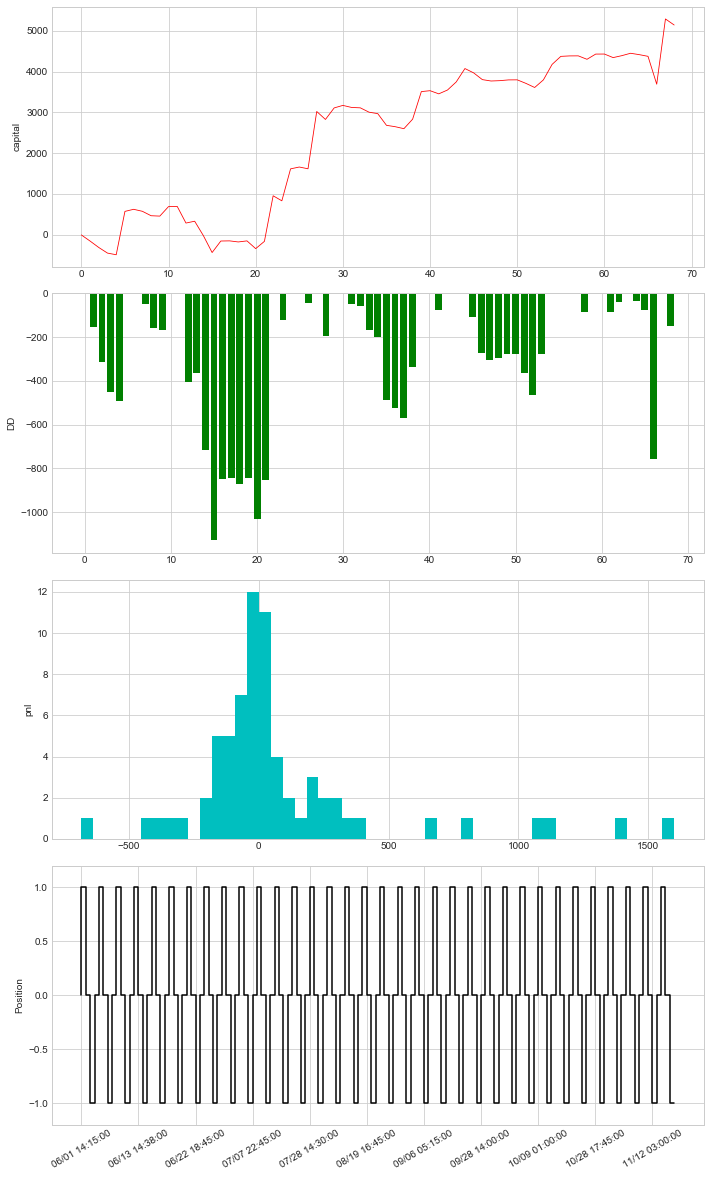

2018-12-17 20:42:03.128577	计算按日统计结果


(               netPnl  slippage  commission  turnover  tradeCount  tradingPnl  \
 date                                                                            
 2018-06-01  -44.40598     0.002     3.74398   7487.96           1      -40.66   
 2018-06-02 -123.99229     0.008    15.12429  30248.58           4     -284.66   
 2018-06-03  106.91000     0.000     0.00000      0.00           0        0.00   
 2018-06-04 -233.02000     0.000     0.00000      0.00           0        0.00   
 2018-06-05 -115.42707     0.004     7.48307  14966.14           2     -188.04   
 2018-06-06   -5.98698     0.004     7.61298  15225.96           2       75.04   
 2018-06-07   40.93000     0.000     0.00000      0.00           0        0.00   
 2018-06-08 -166.60396     0.004     7.57996  15159.92           2      -95.10   
 2018-06-09   17.51000     0.000     0.00000      0.00           0        0.00   
 2018-06-10  381.22000     0.000     0.00000      0.00           0        0.00   
 2018-06-11  546

In [109]:
parameterDict = {'symbolList':['BTCUSDT:binance']}

runBacktesting(TRIMA_CDL, parameterDict, '20180601 12:00', '20181201 12:00', 0.002, 5/10000)